In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [7]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


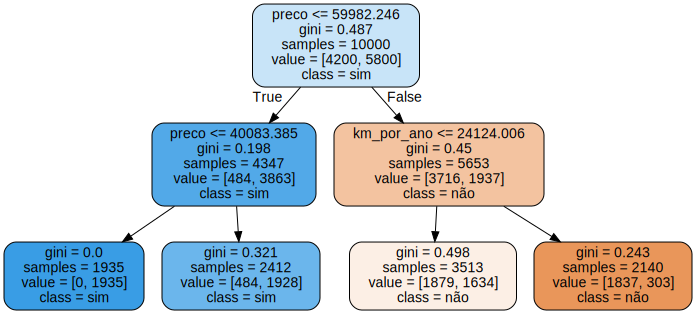

In [10]:
import graphviz
from sklearn.tree import export_graphviz

modelo.fit(x_azar,y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=['não','sim'], feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [11]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


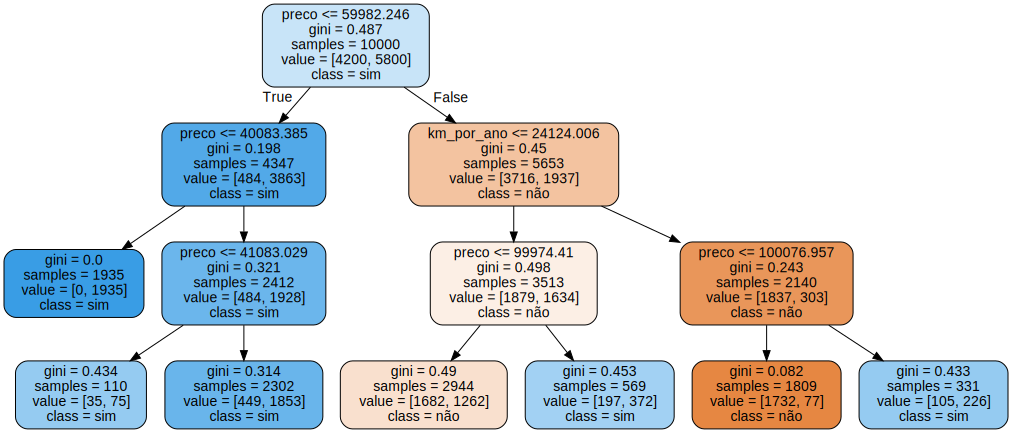

In [13]:
import graphviz
from sklearn.tree import export_graphviz

modelo.fit(x_azar,y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=['não','sim'], feature_names = features)
graph = graphviz.Source(dot_data)
graph

### Explorando hiper parâmetros em uma dimensão

In [24]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

def roda_arvore_de_decisao(profundidade):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=profundidade)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    test_score = results['test_score'].mean() * 100
    train_score = results['train_score'].mean() * 100
    print('max_depth = %d, media_teste = %.2f, media_treino = %.2f' 
        % (profundidade, test_score, train_score))
    tabela = [profundidade, test_score, train_score]
    return tabela
    
resultados = [roda_arvore_de_decisao(i) for i in range(1,33)]

resultados = pd.DataFrame(resultados, columns=["max_depth","test","train"])
resultados.head()

max_depth = 1, media_teste = 75.78, media_treino = 75.79
max_depth = 2, media_teste = 75.78, media_treino = 75.79
max_depth = 3, media_teste = 78.67, media_treino = 78.75
max_depth = 4, media_teste = 78.63, media_treino = 78.79
max_depth = 5, media_teste = 78.56, media_treino = 78.94
max_depth = 6, media_teste = 78.12, media_treino = 79.17
max_depth = 7, media_teste = 77.96, media_treino = 79.50
max_depth = 8, media_teste = 77.86, media_treino = 79.89
max_depth = 9, media_teste = 77.38, media_treino = 80.46
max_depth = 10, media_teste = 77.19, media_treino = 81.16
max_depth = 11, media_teste = 76.97, media_treino = 82.03
max_depth = 12, media_teste = 76.49, media_treino = 82.89
max_depth = 13, media_teste = 75.81, media_treino = 83.95
max_depth = 14, media_teste = 75.66, media_treino = 85.03
max_depth = 15, media_teste = 75.16, media_treino = 86.14
max_depth = 16, media_teste = 75.11, media_treino = 87.19
max_depth = 17, media_teste = 74.74, media_treino = 88.31
max_depth = 18, media_t

,max_depth,test,train
0,1,75.784219,75.791169
1,2,75.784219,75.791169
2,3,78.672633,78.750993
3,4,78.632803,78.787628
4,5,78.555912,78.941007


### Overfitting

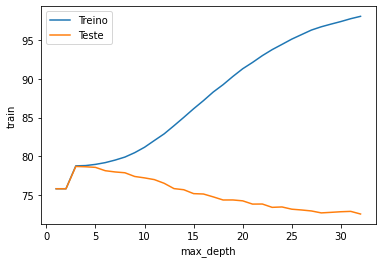

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(x="max_depth",y="train",data=resultados)
sns.lineplot(x="max_depth",y="test",data=resultados)
plt.legend(['Treino','Teste'])

In [28]:
resultados.sort_values("test", ascending=False).head()

,max_depth,test,train
2,3,78.672633,78.750993
3,4,78.632803,78.787628
4,5,78.555912,78.941007
5,6,78.123266,79.170115
6,7,77.963185,79.496806


### Explorando hiper parâmetros em duas dimensões

In [31]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

def roda_arvore_de_decisao(profundidade, amostras_por_folha):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=profundidade,
                                    min_samples_leaf=amostras_por_folha)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    test_score = results['test_score'].mean() * 100
    train_score = results['train_score'].mean() * 100
    tabela = [profundidade, amostras_por_folha, test_score, train_score]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32,64,128,256]:
            for min_samples_split in [1000, 2000, 3000]:
                tabela = roda_arvore_de_decisao(max_depth,min_samples_leaf)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=["max_depth""min_samples_leaf","test","train"])
    return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,test,train
0,1,32,75.784219,75.791169
1,1,64,75.784219,75.791169
2,1,128,75.784219,75.791169
3,1,256,75.784219,75.791169
4,2,32,75.784219,75.791169


In [33]:
corr = resultados.corr()

<AxesSubplot:>

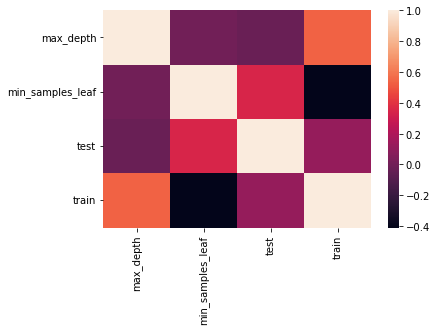

In [34]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test'>,
        <AxesSubplot:xlabel='test', ylabel='test'>,
        <AxesSubplot:xlabel='train', ylabel='test'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train'>,
        <AxesSubplot:xlabel='test', ylabel='train'>,
        <AxesSubplot:xlabel='train', ylabel='train'>]], dtype=object)

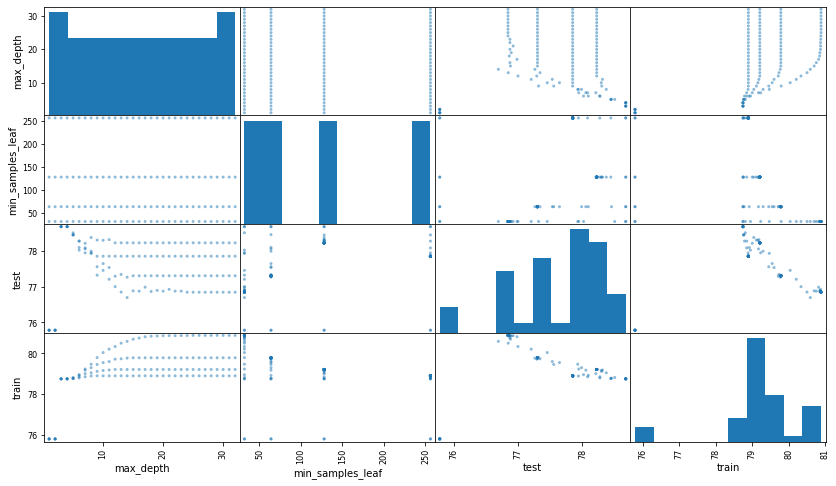

In [38]:
pd.plotting.scatter_matrix(resultados, figsize = (14,8))

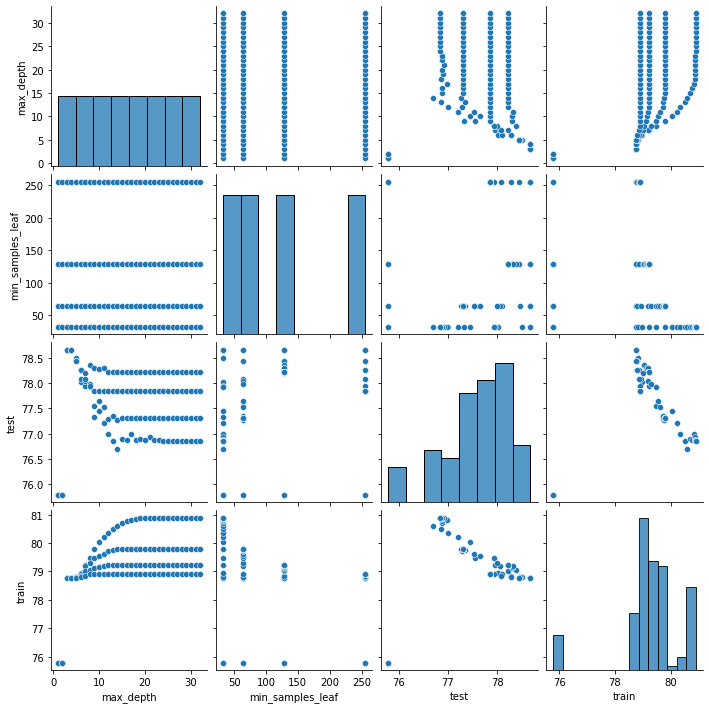

In [39]:
sns.pairplot(resultados)

### Explorando 3 hiper parâmetros

In [43]:
def roda_arvore_de_decisao(profundidade, amostras_por_folha,amostras_para_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=profundidade,
                                    min_samples_split=amostras_para_split, 
                                    min_samples_leaf=amostras_por_folha)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    test_score = results['test_score'].mean() * 100
    train_score = results['train_score'].mean() * 100
    tabela = [profundidade, amostras_para_split, amostras_por_folha, test_score, train_score, fit_time, score_time]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32,64,128,256]:
            for min_samples_split in [1000, 2000, 3000]:
                tabela = roda_arvore_de_decisao(max_depth,min_samples_leaf,min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=["max_depth","min_samples_split","min_samples_leaf","test","train","fit_time","score_time"])
    return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_split,min_samples_leaf,test,train,fit_time,score_time
0,1,1000,32,75.784219,75.791169,0.006995,0.002092
1,1,2000,32,75.784219,75.791169,0.005889,0.001646
2,1,3000,32,75.784219,75.791169,0.005603,0.001699
3,1,1000,64,75.784219,75.791169,0.004669,0.001448
4,1,2000,64,75.784219,75.791169,0.004666,0.001699


In [42]:
resultados.sort_values('test',ascending=False).head()

,max_depth,min_samples_split,min_samples_leaf,test,train
36,4,1000,32,78.672633,78.750993
45,4,1000,256,78.672633,78.750993
30,3,1000,128,78.672633,78.750993
24,3,1000,32,78.672633,78.750993
33,3,1000,256,78.672633,78.750993


# Explorando espaço de hiperparâmetros com GridSearchCV

In [44]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth": [3,5],
    "min_samples_split": [32,64,128],
    "min_samples_leaf": [32,64,128],
    "criterion": ["gini","entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar, groups = dados.modelo)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011159,0.001796,0.001664,0.000409,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.009068,0.000806,0.001466,0.000248,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.008862,0.000445,0.001425,0.000265,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.008982,0.000437,0.001511,0.000163,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.012550,0.003690,0.002372,0.000965,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [47]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [49]:
print(busca.best_estimator_)
melhor = busca.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


In [51]:
from sklearn.metrics import accuracy_score

#evitar abordagem otimista abaixo

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar)
print(accuracy*100)

78.75


# como ter uma estimativa sem vício

Em cross validation com busca de hiper parâmetros, é necessário uma nova validação cruzada

In [52]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits = 10), groups = dados.modelo)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nathan/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nathan/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 875, in fit
    self._run_search(evaluate_candidates)
  File "/home/nathan/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 1375, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/home/nathan/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 834, in evaluate_candidates
    for (cand_idx, parameters), (split_idx, (train, test)) in product(
  File "/home/nathan/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py", line 340, in split
    for train, test in super().split(X, y, groups):
  File "/home/nathan/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py", line 86, in split
    for test_index in self._iter_test_masks(X, y, groups):
  File "/home/nathan/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py", line 98, in _iter_test_masks
    for test_index in self._iter_test_indices(X, y, groups):
  File "/home/nathan/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py", line 514, in _iter_test_indices
    raise ValueError("The 'groups' parameter should not be None.")
ValueError: The 'groups' parameter should not be None.


GroupKFold possui bug

In [53]:
from sklearn.model_selection import GridSearchCV, KFold

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth": [3,5],
    "min_samples_split": [32,64,128],
    "min_samples_leaf": [32,64,128],
    "criterion": ["gini","entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv = KFold(n_splits = 10, shuffle = True))

busca.fit(x_azar, y_azar)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014869,0.001487,0.002648,0.000404,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
1,0.010686,0.001534,0.001654,0.000294,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
2,0.010176,0.000972,0.001817,0.000285,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
3,0.010374,0.001392,0.001681,0.000422,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
4,0.008448,0.000928,0.001380,0.000218,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1


In [54]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits = 10, shuffle = True))

In [56]:
def imprime_score(scores):
    media = scores.mean() * 100
    desvio = scores.std() * 100
    print(f"media {media}")
    print(f"desvio padrão {desvio}")
    
imprime_score(scores)

media 78.69
desvio padrão 1.279413928328122
